In [1]:
# This notebook is for calculating the geodic distance and connectivity distance of functional and structural matrices 
# Includes:
#      loading geodesic distance map and visualize
#      loading functional and structural conn matrices and visualize / compare with geodesic
#      correlation between geodesic and func / struct
#      spin test (whole brain / parcellated brain) correlation

In [1]:
import os
from neuromaps import images
import numpy as np
import nibabel as nib
from sklearn import preprocessing
from surfplot import Plot
from neuromaps.datasets import fetch_fsaverage
from numpy import load
import seaborn as sns
import matplotlib.pyplot as plt
from neuromaps import stats
from neuromaps import datasets, images, nulls, resampling
from neuromaps import parcellate
from brainspace.datasets import load_fsa5
from brainspace.plotting import plot_hemispheres
from brainspace.datasets import load_parcellation
from brainspace.utils.parcellation import map_to_labels
import pandas as pd

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


### Setting path

In [2]:
main_path = "/srv/khan/users/sudesnac/"
#main_path = "/home/ROBARTS/schakraborty/graham/sudesnacPJ/21_Codes/"

In [3]:
note_path = main_path + "/HumanBF-Parcellation/notebook/"
data_path = main_path + "/HumanBF-Parcellation/data/"
results_path = main_path + "/HumanBF-Parcellation/results/Conn_dist/"
fig_path = main_path + "/HumanBF-Parcellation/results/figures/Conn_dist/"

### Load & visualize geodic distance (midthickness)

In [4]:
# Geodic Distance
# data_dir = "/home/ROBARTS/schakraborty/graham/sudesnacPJ/13_Funcparc/0_Funcparc_rhaast/basal_forebrain/resources/"
geodic_lh = images.load_gifti(results_path + "seed-BASF_geodesic-distance-no-zeros.pial.lh.shape.gii")
geodic_rh = images.load_gifti(results_path + "seed-BASF_geodesic-distance-no-zeros.pial.rh.shape.gii")

In [5]:
geodic_lh_data = geodic_lh.agg_data()
geodic_rh_data = geodic_rh.agg_data()
geodic_data = np.concatenate((geodic_lh_data, geodic_rh_data))

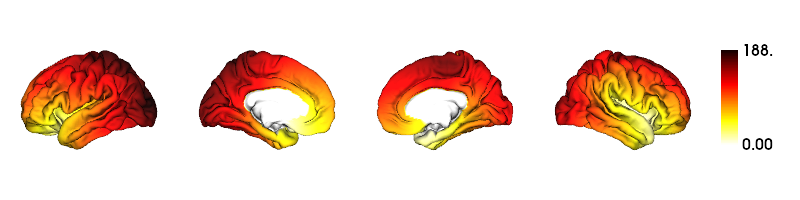

In [6]:
# Checking the cortical surface data
surf_lh, surf_rh = load_fsa5()
plot_hemispheres(surf_lh, surf_rh, array_name=[geodic_data], size=(800, 200), cmap=['hot_r'], color_bar=True, embed_nb=True)

In [6]:
# getting the surface BF data
# seed_dir = "/home/ROBARTS/schakraborty/graham/sudesnacPJ/13_Funcparc/0_Funcparc_rhaast/basal_forebrain/results/funcparc_icafix/group/atlas/"
BF_lh = images.load_gifti(results_path + "seed-BASF.L.bin.fsa5.shape.gii")
BF_rh = images.load_gifti(results_path + "seed-BASF.R.bin.fsa5.shape.gii")

In [7]:
BF_lh_data = BF_lh.agg_data()
BF_rh_data = BF_rh.agg_data()
BF_data = np.concatenate((BF_lh_data, BF_rh_data))

In [8]:
# scale the geodic and BF data 
min_max_scaler = preprocessing.MinMaxScaler()
BF_scaled_data = min_max_scaler.fit_transform(BF_data.reshape(-1, 1))
geodic_scaled_data = min_max_scaler.fit_transform(geodic_data.reshape(-1, 1))

In [10]:
# for displaying all values in numpy
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

In [9]:
# change so the scaled data is binarized
BF_scaled_data = np.where(BF_scaled_data == 0.5, 1, BF_scaled_data)
np.where(BF_scaled_data==1)

(array([   78,   600,  1335,  1337,  2438,  3255,  3256,  3257,  5448,
         5452,  7014,  7015,  8476,  8477,  9873,  9874,  9875,  9878,
         9879,  9880, 10320, 10842, 10920, 11577, 11579, 12203, 12680,
        13497, 13498, 13499, 14546, 15690, 15692, 15694, 17255, 17256,
        17257, 17604, 18136, 18718, 18719, 18725, 18726, 18727, 18728,
        20115, 20116, 20117, 20120, 20121, 20122]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0]))

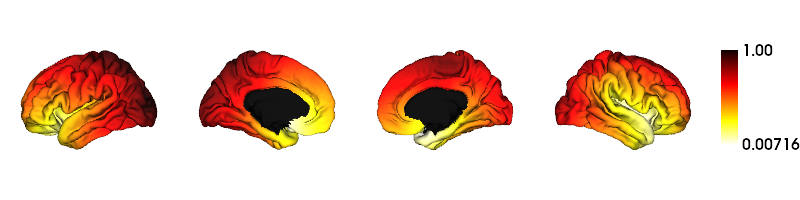

In [20]:
# Checking the scaled cortical surface data
surf_lh, surf_rh = load_fsa5()
plot_hemispheres(surf_lh, surf_rh, array_name=[geodic_scaled_data.reshape([20484])], size=(800, 200), cmap=['hot_r'], color_bar=True, embed_nb=True)

/tmp/ipykernel_217932/1614111137.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


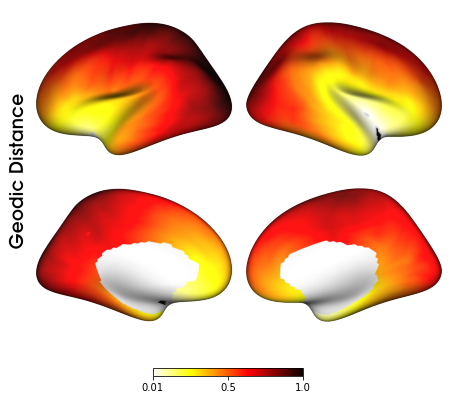

In [11]:
# plot both BF and geodic distance together

surfaces = fetch_fsaverage(density='10k')
lh, rh = surfaces['inflated']

p = Plot(lh, rh, size=(800, 600), zoom=1.5, label_text={'left':['Geodic Distance']}, brightness=.8)
p.add_layer(geodic_scaled_data.reshape([20484]), cmap='hot_r', cbar=True)
p.add_layer(BF_scaled_data.reshape([20484]), cmap='binary', cbar=False)
fig = p.build()
fig.show()
fig.savefig(fig_path+'geodesic_dist_BFseed_grid.png', dpi=300)

### Loading functional and diffusion connectivity data

#### Functional data

In [12]:
from numpy import load
# load npz data
func_data = load(data_path + 'correlation_matrix_HCP-MMP_group.npz')
func_correlation = func_data['corr_group']
func_indices = func_data['indices']

In [13]:
# Average correlation matrix
corr_avg = np.nanmean(func_correlation,axis=0)
corr_avg += 1
corr_avg[np.isnan(corr_avg)] = 1
# remove the subcortical regions 
func_corr_avgFC = corr_avg[:,:-19]

In [14]:
func_ctx = np.nanmean(func_corr_avgFC,axis=0).reshape([360,1])

#### Diffusion data

In [15]:
diff_data = load(data_path + 'tpl-MNI152NLin6Asym_label-fullBF_desc-concat_from-7Tsubj7TDWI_connMap.npz')
dcorrelation = diff_data['conn_group']

In [16]:
# Average correlation matrix
dcorr_avg = np.nanmean(dcorrelation,axis=0)
dcorr_avg += 1
dcorr_avg[np.isnan(dcorr_avg)] = 1

In [17]:
dcorr_avgFC = np.concatenate((dcorr_avg,dcorr_avg), axis=1)
log_dcorr_avgFC = np.log(dcorr_avgFC)

In [18]:
diff_ctx = np.nanmean(log_dcorr_avgFC,axis=0).reshape([360,1])

#### Visualize

In [19]:
# setting up for cortical projection using brainspace
surf_lh, surf_rh = load_fsa5()

surf_labels_lh = nib.freesurfer.read_annot(data_path + 'lh.HCP-MMP1_fsa10.annot')[0]
surf_labels_rh = nib.freesurfer.read_annot(data_path + 'rh.HCP-MMP1_fsa10.annot')[0]
surf_labels_rh[surf_labels_rh != 0] += 180  # different labels for lh and rh
surf_labels = np.concatenate([surf_labels_lh, surf_labels_rh])

mask = surf_labels != 0  # discard medial wall

In [20]:
func_cortex = map_to_labels(func_ctx.reshape([360]),surf_labels, mask=mask, fill=np.nan)
diff_cortex = map_to_labels(diff_ctx.reshape([360]),surf_labels, mask=mask, fill=np.nan)

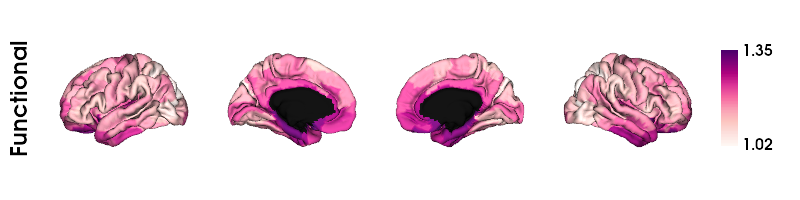

In [34]:
surf_lh, surf_rh = load_fsa5()
plot_hemispheres(surf_lh, surf_rh, array_name=[func_cortex], size=(800, 200), cmap=['RdPu'], label_text=['Functional'], color_bar=True, embed_nb=True)

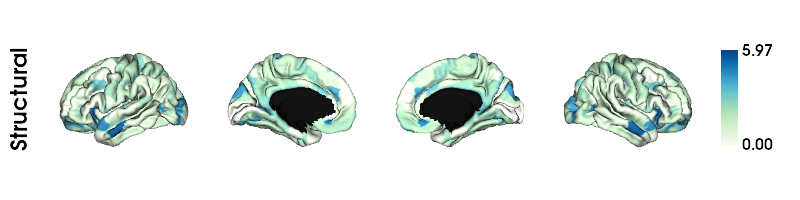

In [35]:
surf_lh, surf_rh = load_fsa5()
plot_hemispheres(surf_lh, surf_rh, array_name=[diff_cortex], size=(800, 200), cmap=['GnBu'], label_text=['Structural'], color_bar=True, embed_nb=True)

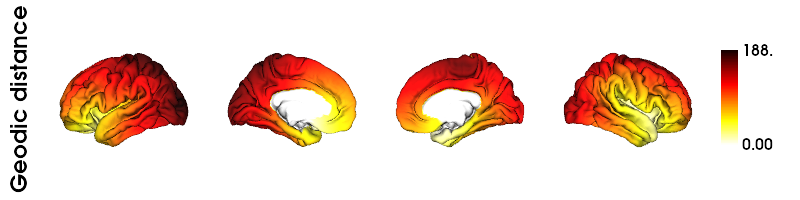

In [36]:
# Checking the cortical surface data
surf_lh, surf_rh = load_fsa5()
plot_hemispheres(surf_lh, surf_rh, array_name=[geodic_data], size=(800, 200), cmap=['hot_r'], label_text=['Geodic distance'], color_bar=True, embed_nb=True)

#### Rescale data

In [21]:
# scale the  data 
min_max_scaler = preprocessing.MinMaxScaler()
func_scaled_ctx = min_max_scaler.fit_transform(func_cortex.reshape(-1, 1))
diff_scaled_ctx = min_max_scaler.fit_transform(diff_cortex.reshape(-1, 1))

In [22]:
gdist_data = {'labels':surf_labels.reshape([20484]), 'geodesic':geodic_scaled_data.reshape([20484]), 'functional':func_scaled_ctx.reshape([20484]), 'structural':diff_scaled_ctx.reshape([20484])}
gdist_df = pd.DataFrame(data=gdist_data)

In [23]:
gdist_df

,labels,geodesic,functional,structural
0,54,0.830015,0.469834,0.352849
1,46,0.949578,0.210992,0.458687
2,41,0.588710,0.521383,0.228989
3,87,0.575560,0.341724,0.218533
4,99,0.469147,0.377407,0.131574
...,...,...,...,...
20479,314,0.354762,0.777940,0.262293
20480,314,0.334636,0.777940,0.262293
20481,315,0.316892,0.813672,0.319116
20482,315,0.325262,0.813672,0.319116


In [34]:
# set the geodesic medial wall to nan instead of 0 to match with other 
gdist_df.loc[gdist_df.labels == 0, 'geodesic'] = np.nan

In [71]:
pd.set_option('display.max_rows', None)
gdist_df.loc[(gdist_df['geodesic'] == 0) & ~ np.isnan(gdist_df['structural'])]

,labels,geodesic,functional,structural
147,110,0.0,0.892267,0.141000
161,120,0.0,0.900412,0.572058
328,120,0.0,0.900412,0.572058
329,120,0.0,0.900412,0.572058
358,120,0.0,0.900412,0.572058
598,110,0.0,0.892267,0.141000
639,120,0.0,0.900412,0.572058
640,120,0.0,0.900412,0.572058
808,120,0.0,0.900412,0.572058
967,110,0.0,0.892267,0.141000


In [35]:
pd.DataFrame(gdist_df).to_csv(results_path + 'rescaled_geodesic_func_struct_data.csv', index=False)

In [36]:
gdist_df = pd.read_csv(results_path + 'rescaled_geodesic_func_struct_data.csv')

/tmp/ipykernel_217932/2715494554.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


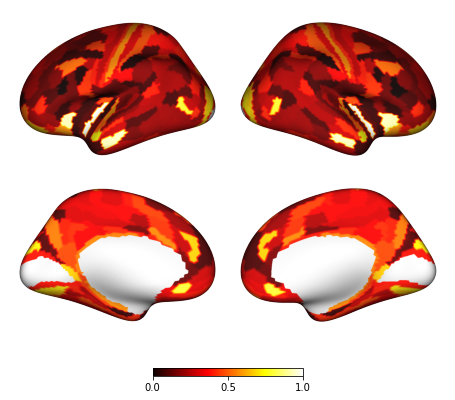

In [69]:
# Visualize
# plot both BF and geodic distance together

surfaces = fetch_fsaverage(density='10k')
lh, rh = surfaces['inflated']

p = Plot(lh, rh, size=(800, 600), zoom=1.5, brightness=.8)
#p.add_layer(geodic_scaled_data.reshape([20484]), cmap='hot_r', cbar=True)
#p.add_layer(BF_scaled_data.reshape([20484]), cmap='binary', cbar=False)
#p.add_layer(func_scaled_ctx.reshape([20484]), cmap='hot', cbar=True)
p.add_layer(diff_scaled_ctx.reshape([20484]), cmap='hot', cbar=True)
fig = p.build()
fig.show()
fig.savefig(fig_path+'structural_connectivity_grid.png', dpi=300)

### Correlations

#### scatter plots

In [37]:
from matplotlib.colors import ListedColormap
from brainstat.datasets import fetch_mask, fetch_template_surface
from brainstat.datasets import fetch_parcellation
from brainspace.plotting.surface_plotting import plot_hemispheres
from brainstat.datasets import fetch_yeo_networks_metadata

surfaces = fetch_template_surface("fsaverage5", join=False)
yeo_networks = fetch_parcellation("fsaverage5", "yeo", 7)
network_names, yeo_colormap = fetch_yeo_networks_metadata(7)
yeo_colormap_gray = np.concatenate((np.array([[0.7, 0.7, 0.7]]), yeo_colormap))
yeoCols = ListedColormap(yeo_colormap_gray)

/tmp/ipykernel_217932/920395820.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


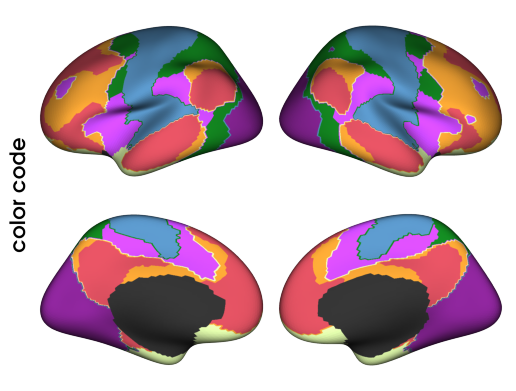

In [38]:
# Visualize
# plot both BF and geodic distance together

surfaces = fetch_fsaverage(density='10k')
lh, rh = surfaces['inflated']

p = Plot(lh, rh, size=(800, 600), label_text={'left':['color code']}, brightness=.8)
p.add_layer(yeo_networks, cmap=yeoCols, cbar=False)
# p.add_layer(geodic_scaled_data.reshape([20484]), cmap='hot_r', cbar=True)
# p.add_layer(BF_scaled_data.reshape([20484]), cmap='binary_r', cbar=False)
# p.add_layer(func_scaled_ctx.reshape([20484]), cmap='RdPu', cbar=True)
# p.add_layer(diff_scaled_ctx.reshape([20484]), cmap='GnBu', cbar=True)
fig = p.build()
fig.show()

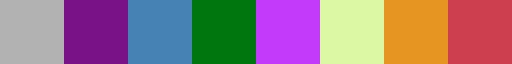

In [72]:
yeoCols

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


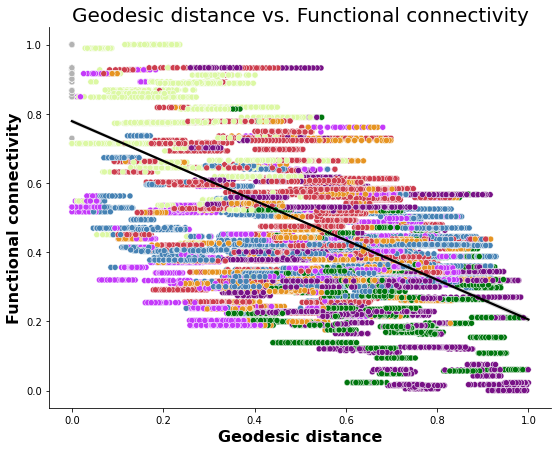

In [39]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(gdist_df['geodesic'], gdist_df['functional'], hue=yeo_networks, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_ylabel('Functional connectivity', weight='bold', fontsize=16)
ax1.set_xlabel('Geodesic distance', weight='bold', fontsize=16)

plt.title("Geodesic distance vs. Functional connectivity", fontsize=20)
# Add fit line
sns.regplot(
    x=func_scaled_ctx,
    y=geodic_scaled_data,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.savefig(fig_path + f'Geodesic_distance_vs_Functional_connectivity.png', dpi=300)

plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


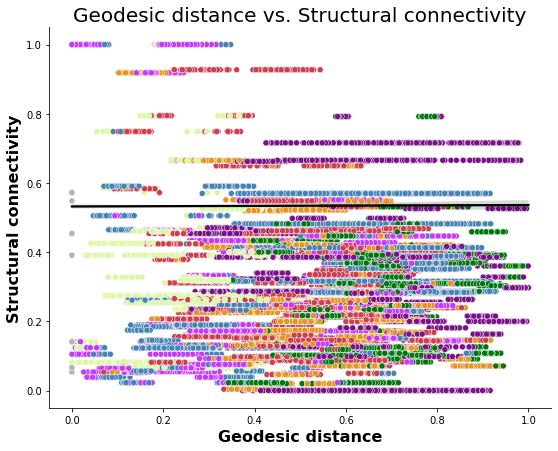

In [40]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(gdist_df['geodesic'], gdist_df['structural'], hue=yeo_networks, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_ylabel('Structural connectivity', weight='bold', fontsize=16)
ax1.set_xlabel('Geodesic distance', weight='bold', fontsize=16)

plt.title("Geodesic distance vs. Structural connectivity", fontsize=20)
# Add fit line
sns.regplot(
    x=diff_scaled_ctx,
    y=geodic_scaled_data,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.savefig(fig_path + f'Geodesic_distance_vs_Structural_connectivity.png', dpi=300)

plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


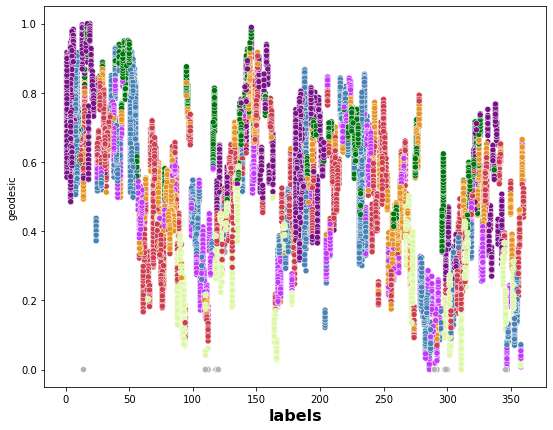

In [79]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(gdist_df['labels'], gdist_df['geodesic'], hue=yeo_networks, palette=yeoCols)
ax1.legend([],[], frameon=False)
#ax1.set_ylabel('labels', weight='bold', fontsize=16)
ax1.set_xlabel('labels', weight='bold', fontsize=16)

plt.show()

### Null models

#### whole surface

In [61]:
#geodesic_scaled_data = geodic_scaled_data.reshape([20484])
#func_scaled_data = func_scaled_ctx.reshape([20484])
#diff_scaled_data = diff_scaled_ctx.reshape([20484])

In [51]:
geodesic_scaled_data = gdist_df['geodesic'].values
func_scaled_data = gdist_df['functional'].values
diff_scaled_data = gdist_df['structural'].values

In [52]:
alex_geodesic_rotated = nulls.alexander_bloch(geodesic_scaled_data, atlas='fsaverage', density='10k', n_perm=2000, seed=1234)

In [53]:
alex_geodesic_rotated.shape

(20484, 2000)

In [54]:
fcgc_corr, fcgc_pval = stats.compare_images(geodic_scaled_data,func_scaled_data, nulls=alex_geodesic_rotated)
fcgc_corr, fcgc_pval

(-0.4389252093073986, 0.13993003498250875)

In [55]:
dcgc_corr, dcgc_pval = stats.compare_images(geodic_scaled_data,diff_scaled_data, nulls=alex_geodesic_rotated)
dcgc_corr, dcgc_pval

(0.0613053989524191, 0.7201399300349826)

#### parcellated data

In [99]:
#glasser_parc = fetch_parcellation("fsaverage5", "glasser", 360)

In [56]:
# load the hcp-mmp1 parcellation gii file
hcpmmp_lh = images.load_gifti(data_path + 'glasser_360_fsaverage5_lhlabel.gii')
hcpmmp_rh = images.load_gifti(data_path + 'glasser_360_fsaverage5_rhlabel.gii')

In [57]:
# combine lh and rh (and make the labels order consecutive)
hcpmmp_parcellation = images.relabel_gifti((hcpmmp_lh, hcpmmp_rh))

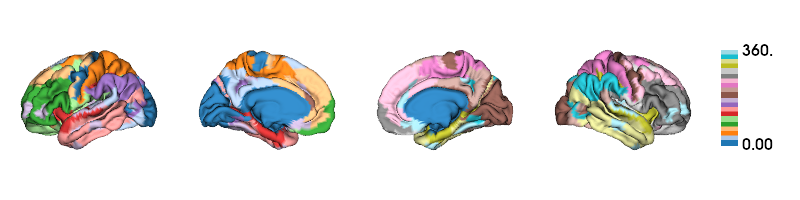

In [102]:
# visualize the parcellation data to double check
hm_lh, hm_rh = hcpmmp_parcellation
parc_L_data = hm_lh.agg_data()
parc_R_data = hm_rh.agg_data()
parc_data = np.concatenate((parc_L_data, parc_R_data))
surf_lh, surf_rh = load_fsa5()
plot_hemispheres(surf_lh, surf_rh, array_name=[parc_data], size=(800, 200), cmap=['tab20'], color_bar=True, embed_nb=True)

In [58]:
# create parcellater
hcpmmp = parcellate.Parcellater(hcpmmp_parcellation, 'fsaverage').fit()

In [59]:
geodesic_parc = hcpmmp.transform(geodesic_scaled_data, 'fsaverage', ignore_background_data=True)

In [60]:
# geodisic_parc = hcpmmp.transform(geodic_scaled_data, 'fsaverage')
func_parc = hcpmmp.transform(func_scaled_ctx, 'fsaverage', ignore_background_data=True)
diff_parc = hcpmmp.transform(diff_scaled_ctx, 'fsaverage', ignore_background_data=True)

In [90]:
# from neuromaps.nulls.spins import vertices_to_parcels
# geodesic_parc = vertices_to_parcels(geodic_scaled_data, hcpmmp_parcellation)
# func_parc = vertices_to_parcels(func_scaled_ctx, hcpmmp_parcellation)
# diff_parc = vertices_to_parcels(diff_scaled_ctx, hcpmmp_parcellation)

In [61]:
geodisic_parc_rotated = nulls.alexander_bloch(geodesic_parc, atlas='fsaverage', density='10k',
                                n_perm=2000, seed=1234, parcellation=hcpmmp_parcellation)

In [62]:
pc_fcgc_corr, pc_fcgc_pval = stats.compare_images(geodesic_parc,func_parc, nulls=geodisic_parc_rotated)
pc_fcgc_corr, pc_fcgc_pval

(-0.5599485039710999, 0.04547726136931534)

In [63]:
pc_dcgc_corr, pc_dcgc_pval = stats.compare_images(geodesic_parc,diff_parc, nulls=geodisic_parc_rotated)
pc_dcgc_corr, pc_dcgc_pval

(-0.006972446106374264, 0.967016491754123)